# Augmentation vs no augmenation σε μία απλή αρχιτεκτονικη για το dataset MNIST

In [1]:
!pip install opencv-python

In [0]:
import torch, numpy as np
from torchvision import datasets, transforms
import cv2
import matplotlib.pyplot as plt

Φορτώνουμε τα δεδομένα του MNIST σε 2 data loaders.

In [0]:
BATCH_SIZE = 32

train_loader = torch.utils.data.DataLoader(
        datasets.MNIST('../data', train=True, download=True,
                       transform=transforms.ToTensor()),
        batch_size=BATCH_SIZE, shuffle=True, drop_last=True)

test_loader = torch.utils.data.DataLoader(
        datasets.MNIST('../data', train=False, download=True,
                       transform=transforms.ToTensor()),
        batch_size=BATCH_SIZE, shuffle=True, drop_last=True)

Χρησιμοποιούμε την GPU του συστήματος.

In [3]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device

device(type='cuda', index=0)

In [4]:
(len(train_loader))*BATCH_SIZE

60000

Οπτικοποίηση μη augmented δεδομένων.

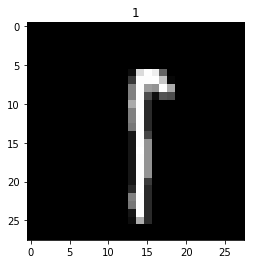

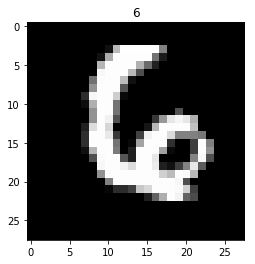

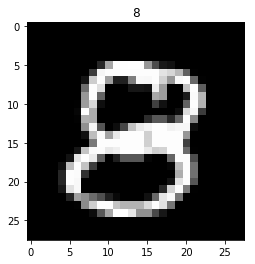

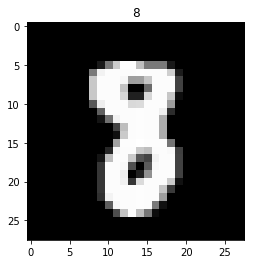

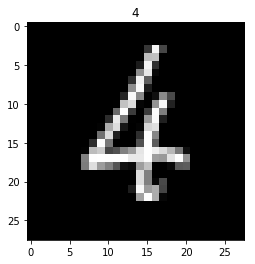

In [5]:
images, labels = list(train_loader)[0]
for i in range(5):
      plt.imshow(images[i, 0, :, :], cmap='gray')
      plt.title(labels[i].item())
      plt.show()

In [0]:
import torch.nn as nn
import torch.nn.functional as functions
import torch.optim as optim

Ορίζουμε την βασική αρχιτεκτονική που θα χρησιμοποιήσουμε. Πρόκειται για ένα convolutional network με ReLU και max pool layers. Η διάσταση του τελικού σταδίου είναι 10 (όσες και οι διαφορετικές κλάσεις του MNIST)

In [0]:
#class LinearNet(nn.Module):
#  def __init__(self, input_dim, output_dim):
#    super(LinearNet, self).__init__()
#    self.fc1 = nn.Linear(input_dim, output_dim)
#  
#  def forward(self, x):
#    x = x.view(-1, 28*28)
#    x = self.fc1(x)
#    return x
 # I was trying to see the effect of augmentation on simpler models. It serves no purpose in the current demo. 

class BasicCNN(nn.Module):
  def __init__(self, input_dim, output_dim):
    super(BasicCNN, self).__init__()
    self.input_dim = input_dim
    self.output_dim = output_dim
    self.convolutional_layer = nn.Sequential(nn.Conv2d(in_channels=self.input_dim, out_channels=12, kernel_size=4),
                                nn.ReLU(inplace=True),
                                nn.MaxPool2d(kernel_size=5)
                               )
    self.classifier_layer = nn.Linear(12*5*5, self.output_dim)
   
  def forward(self, x):
    x = self.convolutional_layer(x)
    x = x.view(BATCH_SIZE, -1)
    return self.classifier_layer(x)
    

In [0]:
def train(epoch, train_data, model):
  model.train()
  for batch_idx, (data, target) in enumerate(train_data):
    data = data.to(device)
    target = target.to(device)
    optimizer.zero_grad()
    output = model(data)
    loss = loss_function(output, target)
    loss.backward()
    optimizer.step()
    if batch_idx % 480 == 0:
      print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
        epoch, batch_idx * len(data), len(train_data.dataset),
        100. * batch_idx / len(train_data), loss.item()))
      train_losses.append(loss.item())
      train_counter.append(
        (batch_idx*64) + ((epoch-1)*len(train_data.dataset)))
      
      
def test(model):
  model.eval()
  test_loss = 0
  correct = 0
  with torch.no_grad():
    for data, target in test_loader:
      data = data.to(device)
      target = target.to(device)
      output = model(data)
      test_loss += loss_function(output, target).item()
      pred = output.data.max(1, keepdim=True)[1]
      correct += pred.eq(target.data.view_as(pred)).sum()
  test_loss /= len(test_loader.dataset)
  test_losses.append(test_loss)
  print('\nTest set: Avg. loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
    test_loss, correct, len(test_loader.dataset),
    100. * correct / len(test_loader.dataset)))

Εκπαιδεύουμε για 5 εποχές το δίκτυο με τα μη augmented δεδομένα.

In [9]:
input_dim = 1
output_dim = 10
n_epochs = 5

model = BasicCNN(input_dim, output_dim).to(device)
loss_function = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

train_losses = []
train_counter = []
test_losses = []
test_counter = [i*len(train_loader.dataset) for i in range(n_epochs + 1)]

test(model)
for epoch in range(1, n_epochs + 1):
  train(epoch, train_loader, model)
  test(model)


Test set: Avg. loss: 0.0721, Accuracy: 1256/10000 (12%)

Train Epoch: 1 [0/60000 (0%)]	Loss: 2.351829
Train Epoch: 1 [15360/60000 (26%)]	Loss: 0.061608
Train Epoch: 1 [30720/60000 (51%)]	Loss: 0.127023
Train Epoch: 1 [46080/60000 (77%)]	Loss: 0.020636

Test set: Avg. loss: 0.0026, Accuracy: 9737/10000 (97%)

Train Epoch: 2 [0/60000 (0%)]	Loss: 0.296270
Train Epoch: 2 [15360/60000 (26%)]	Loss: 0.001738
Train Epoch: 2 [30720/60000 (51%)]	Loss: 0.181637
Train Epoch: 2 [46080/60000 (77%)]	Loss: 0.027298

Test set: Avg. loss: 0.0020, Accuracy: 9781/10000 (97%)

Train Epoch: 3 [0/60000 (0%)]	Loss: 0.043849
Train Epoch: 3 [15360/60000 (26%)]	Loss: 0.011739
Train Epoch: 3 [30720/60000 (51%)]	Loss: 0.155131
Train Epoch: 3 [46080/60000 (77%)]	Loss: 0.179528

Test set: Avg. loss: 0.0022, Accuracy: 9761/10000 (97%)

Train Epoch: 4 [0/60000 (0%)]	Loss: 0.039279
Train Epoch: 4 [15360/60000 (26%)]	Loss: 0.000464
Train Epoch: 4 [30720/60000 (51%)]	Loss: 0.154990
Train Epoch: 4 [46080/60000 (77%)]	Los

Ορίζουμε 3 τεχνικές augmentation των οποίων την καταλληλότητα θα ελέγξουμε για το παρόν dataset. Πρόκειται για:


*   Gaussian smoothing
*   Μορφολογική παράγωγο
*   Τυχαία περιστροφή (από 45 μέχρι -45 μοίρες)

Σε κάθε εικόνα με πιθανότητα $p = 0.8$ εφαρμόζεται **μία** εκ των παραπάνω τεχνικών. Με πιθανότητα $p = 0.2$ η εικόνα δεν υπόκειται αλλαγή. Πρόκειται για αρκετά "επιθετικό" augmentation.



In [0]:
def smoothen(img):
  scale = (5,5)
  return cv2.GaussianBlur(np.asarray(img), scale, 0)

def gradient(img):
  kernel = np.ones((2,2),np.uint8)
  return cv2.morphologyEx(np.asarray(img), cv2.MORPH_GRADIENT, kernel)

img_transforms = transforms.Compose([transforms.RandomApply([transforms.RandomChoice([transforms.Lambda(smoothen), transforms.Lambda(gradient), transforms.RandomRotation(degrees=45)])], p=0.8), transforms.ToTensor()])

train_loader_aug = torch.utils.data.DataLoader(
        datasets.MNIST('../data', train=True, download=True,
                       transform=img_transforms),
        batch_size=BATCH_SIZE, shuffle=True, drop_last=True)

Οπτικοποίηση του augmented dataset. Βλέπουμε για παράδειγμα πως η 4η εικόνα έχει υποστεί μορφολογικό φιλτράρισμα και έχει μείνει μονάχα το περίγραμμα του ψηφίου. Αν αλλάξετε τον μετρητή στο παρακάτω loop θα εμφανιστούν και άλλα παραδείγματα τέτοιων εικόνων. 

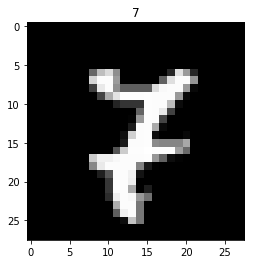

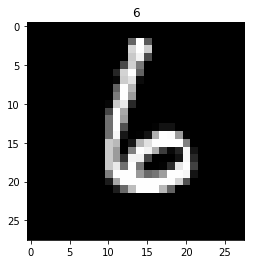

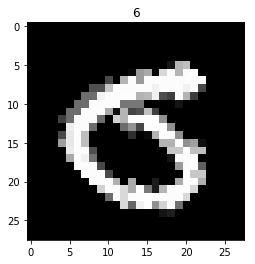

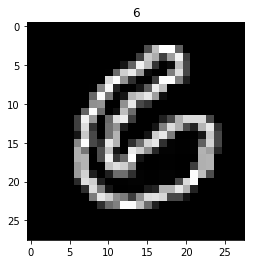

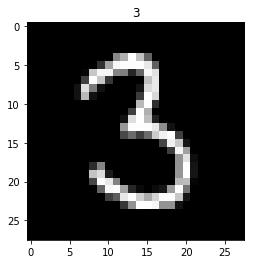

In [11]:
images, labels = list(train_loader_aug)[0]
for i in range(5):
    plt.imshow(images[i, 0, :, :], cmap='gray')
    images[i, 0, :, :].size()
    plt.title(labels[i].item())
    plt.show()

In [14]:
model_aug = BasicCNN(input_dim, output_dim).to(device)
optimizer = torch.optim.Adam(model_aug.parameters(), lr=0.01)
train_losses = []
train_counter = []
test_losses = []
test_counter = [i*len(train_loader_aug.dataset) for i in range(n_epochs + 1)]

test(model_aug)
for epoch in range(1, n_epochs + 1):
  train(epoch, train_loader_aug, model_aug)
  test(model_aug)


Test set: Avg. loss: 0.0741, Accuracy: 1049/10000 (10%)

Train Epoch: 1 [0/60000 (0%)]	Loss: 2.407046
Train Epoch: 1 [15360/60000 (26%)]	Loss: 0.223404
Train Epoch: 1 [30720/60000 (51%)]	Loss: 0.235433
Train Epoch: 1 [46080/60000 (77%)]	Loss: 0.309411

Test set: Avg. loss: 0.0048, Accuracy: 9519/10000 (95%)

Train Epoch: 2 [0/60000 (0%)]	Loss: 0.170665
Train Epoch: 2 [15360/60000 (26%)]	Loss: 0.141460
Train Epoch: 2 [30720/60000 (51%)]	Loss: 0.298921
Train Epoch: 2 [46080/60000 (77%)]	Loss: 0.039870

Test set: Avg. loss: 0.0038, Accuracy: 9635/10000 (96%)

Train Epoch: 3 [0/60000 (0%)]	Loss: 0.034392
Train Epoch: 3 [15360/60000 (26%)]	Loss: 0.338876
Train Epoch: 3 [30720/60000 (51%)]	Loss: 0.195852
Train Epoch: 3 [46080/60000 (77%)]	Loss: 0.139065

Test set: Avg. loss: 0.0039, Accuracy: 9640/10000 (96%)

Train Epoch: 4 [0/60000 (0%)]	Loss: 0.087395
Train Epoch: 4 [15360/60000 (26%)]	Loss: 0.054545
Train Epoch: 4 [30720/60000 (51%)]	Loss: 0.276153
Train Epoch: 4 [46080/60000 (77%)]	Los

Παρατηρούμε παρόμοια ποιότητα ταξινόμησης των ψηφίων στο test set, ακόμα και για το augmented dataset, στο οποίο υπενθυμίζουμε πως κατά μέσο όρο έχει αλλάξει το 80% των δεδομένων του. Επομένως, οι τεχνικές που χρησιμοποιήθηκαν σίγουρα δεν βλάπτουν τη δυνατότητα γενίκευσης του δικτύου και πιθανώς σε απλούστερα δίκτυα να είναι και ωφέλιμες. Σε κάθε περίπτωση στόχος του συγκεκριμένου notebook ήταν περισσότερο το να πειραματιστούμε με ορισμένες augmentation τεχνικές και λιγότερο να βρούμε μία καλή αρχιτεκτονική για το MNIST.